In [100]:
import pandas as pd
import math
from pydub import AudioSegment
import matplotlib.pyplot as plt
from glob import glob
import os
import shutil
import torchaudio
import torch

In [101]:
csv_path = '../data/tira-asr-hf/metadata-combined.csv'
df=pd.read_csv(csv_path)
df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name,path,...,wada_snr,nist_stnr,speaker-diarization-3.1,voice-activity-detection,whisper-large-v3,clapipa-transcription-allosaurus,vad_s,drz_s,trans_len,pcnt_speech
0,184240.0,189330.0,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,HH20220719-1-m03s04ms240-m03s09ms330.wav,...,14.081620,25.00,0.031 5.009 SPEAKER_00,0.031 3.642 SPEECH;4.098 4.942 SPEECH,ለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለ...,0.7697,4.455,4.978,64,0.875246
1,271280.0,272310.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,HH20220719-1-m04s31ms280-m04s32ms310.wav,...,5.625207,16.25,0.031 1.094 SPEAKER_00,0.098 1.043 SPEECH,hingga nganginya,0.7191,0.945,1.063,15,0.917476
2,275030.0,276050.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,HH20220719-1-m04s35ms030-m04s36ms050.wav,...,4.222627,20.00,0.031 1.060 SPEAKER_00,0.031 0.959 SPEECH,Gak ngalirnya,0.5247,0.928,1.029,15,0.909804
3,304295.0,305015.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,HH20220719-1-m05s04ms295-m05s05ms015.wav,...,2.189131,3.50,0.031 0.773 SPEAKER_00,0.031 0.723 SPEECH,gone already now,0.1008,0.692,0.742,15,0.961111
4,331510.0,333800.0,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,HH20220719-1-m05s31ms510-m05s33ms800.wav,...,15.113453,26.00,0.031 2.191 SPEAKER_00,0.031 2.191 SPEECH,Ngini ngroto tawoni.,0.7299,2.160,2.160,29,0.943231


In [102]:
df['trans_len']=df['transcription'].str.len()
df['trans_len'][:10]

0    64
1    15
2    15
3    15
4    29
5    29
6    29
7    29
8    29
9    63
Name: trans_len, dtype: int64

In [122]:
df['trans_len_log']=df['trans_len'].apply(math.log)
df['cos_sim_softmax']=torch.softmax(torch.Tensor(df['clap_ipa_cos_sim']), dim=0)
df['cos_sim_log']=df['cos_sim_softmax'].apply(math.log)
df['trans_len_log'], df['cos_sim_softmax']


(0        4.158883
 1        2.708050
 2        2.708050
 3        2.708050
 4        3.367296
            ...   
 23456    3.465736
 23457    3.465736
 23458    3.295837
 23459    2.564949
 23460    2.890372
 Name: trans_len_log, Length: 23461, dtype: float64,
 0        0.000042
 1        0.000036
 2        0.000037
 3        0.000040
 4        0.000046
            ...   
 23456    0.000045
 23457    0.000045
 23458    0.000040
 23459    0.000044
 23460    0.000046
 Name: cos_sim_softmax, Length: 23461, dtype: float32)

In [123]:
df[['trans_len', 'trans_len_log', 'clap_ipa_cos_sim', 'cos_sim_softmax', 'cos_sim_log', 'clapipa-transcription-allosaurus', 'nist_stnr', 'wada_snr']].corr('pearson')

,trans_len,trans_len_log,clap_ipa_cos_sim,cos_sim_softmax,cos_sim_log,clapipa-transcription-allosaurus,nist_stnr,wada_snr
trans_len,1.000000,0.941442,0.135787,0.134313,0.135787,0.314145,0.072460,0.066681
trans_len_log,0.941442,1.000000,0.197276,0.198808,0.197276,0.370748,0.064069,0.043705
clap_ipa_cos_sim,0.135787,0.197276,1.000000,0.993525,1.000000,0.451776,-0.017467,-0.036883
cos_sim_softmax,0.134313,0.198808,0.993525,1.000000,0.993525,0.448111,-0.020412,-0.041530
cos_sim_log,0.135787,0.197276,1.000000,0.993525,1.000000,0.451776,-0.017467,-0.036883
clapipa-transcription-allosaurus,0.314145,0.370748,0.451776,0.448111,0.451776,1.000000,0.061152,-0.006004
nist_stnr,0.072460,0.064069,-0.017467,-0.020412,-0.017467,0.061152,1.000000,0.731698
wada_snr,0.066681,0.043705,-0.036883,-0.041530,-0.036883,-0.006004,0.731698,1.000000


<Axes: >

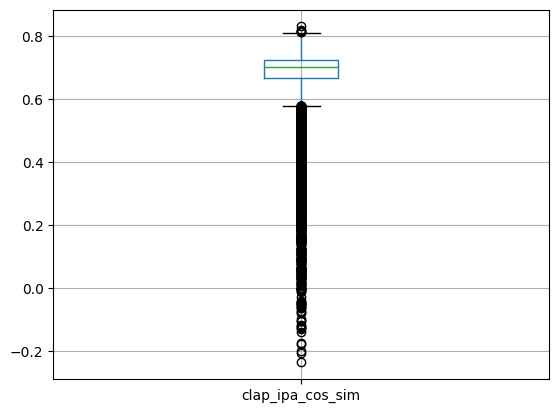

In [126]:
df.boxplot('clap_ipa_cos_sim')

In [127]:
cos_sim_06 = df.loc[
    df['clap_ipa_cos_sim']<0.6,
    ['transcription', 'allosaurus', 'clip', 'clap_ipa_cos_sim', 'clapipa-transcription-allosaurus']
]
cos_sim_06

,transcription,allosaurus,clip,clap_ipa_cos_sim,clapipa-transcription-allosaurus
1,íŋgáŋâɽìɲǎ,ɲ i n k a ŋ n a d i ɲ a,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,0.523998,0.7191
2,íŋgáŋâɽìɲǎ,i ɲ t a ŋ a ɲ j a,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,0.527971,0.5247
12,án âjt̪ɔ́ ŋíðə̀nɔ́ŋ ŋʊ̀rɔ́t̪ɛ̌ íŋgáŋâɽìɲà,e t e ɛ n ŋ l o ð ɛ n o n b r a t e a l ɲ a,data/tira-asr/clips/HH20220719-1-m07s06ms700-m...,0.572309,0.5415
14,án âjt̪ɔ́ ŋíðə̀nɔ́ŋ ŋʊ̀rɔ́t̪ɛ̌ íŋgáŋâɽìɲà,b e t̪ ɔ ŋ n a ð i n ɔ ŋ r a k e a e ɲ a,data/tira-asr/clips/HH20220719-1-m07s21ms110-m...,0.571611,0.6405
15,ŋìðə̀nɔ́,NaN,data/tira-asr/clips/HH20220719-1-m07s43ms125-m...,0.563886,0.1548
...,...,...,...,...,...
23324,ŋgɔ́ nɔ́nà ùt̪ùlú nd̪ɔ̀bà ŋgɔ́ nɔ́nà ùt...,ʂ e k a n ʂ i ŋ ɡ a n o t o l o n d ə b a n b ...,data/tira-asr/clips/HH20230608-m56s23ms432-m56...,0.302296,0.5559
23354,ùcùl,o ʂ o,data/tira-asr/clips/HH20221024-m14s56ms510-m14...,0.358558,0.4436
23436,kàrɔ́ àprí t̪àŋó àprí,k a ɡ o ʂ a ŋ m o a p e i t̪ a ʂ,data/tira-asr/clips/HH20210830-m27s01ms608-m27...,0.494360,0.5151
23440,kàrɔ́ t̪àŋòŋ,k a l o t a ŋ m u m j e ʂ,data/tira-asr/clips/HH20210830-m29s13ms648-m29...,0.577541,0.4892


In [128]:
audio=AudioSegment.from_wav('../'+cos_sim_06.iloc[2350]['clip'])
audio

<Axes: >

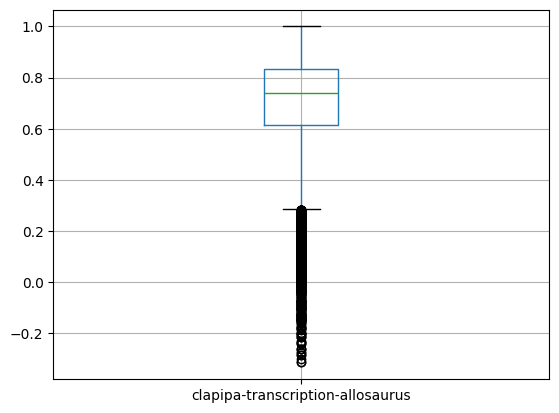

In [129]:
df.boxplot('clapipa-transcription-allosaurus')

In [130]:
clap_allo_06 = df.loc[
    df['clapipa-transcription-allosaurus']<0.6,
    ['transcription', 'allosaurus', 'clip', 'clap_ipa_cos_sim', 'clapipa-transcription-allosaurus']
]
clap_allo_06

,transcription,allosaurus,clip,clap_ipa_cos_sim,clapipa-transcription-allosaurus
2,íŋgáŋâɽìɲǎ,i ɲ t a ŋ a ɲ j a,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,0.527971,0.5247
3,íŋgáŋâɽìɲǎ,t a ŋ v a,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,0.616754,0.1008
12,án âjt̪ɔ́ ŋíðə̀nɔ́ŋ ŋʊ̀rɔ́t̪ɛ̌ íŋgáŋâɽìɲà,e t e ɛ n ŋ l o ð ɛ n o n b r a t e a l ɲ a,data/tira-asr/clips/HH20220719-1-m07s06ms700-m...,0.572309,0.5415
13,ŋìðə̀nɔ̂ŋ́,n o,data/tira-asr/clips/HH20220719-1-m07s10ms510-m...,0.697518,0.0201
15,ŋìðə̀nɔ́,NaN,data/tira-asr/clips/HH20220719-1-m07s43ms125-m...,0.563886,0.1548
...,...,...,...,...,...
23441,kàrɔ́ t̪àŋòŋ,k a t a ŋ,data/tira-asr/clips/HH20210830-m29s20ms672-m29...,0.731578,0.3562
23447,t̪àrɔ́t̪ɛ́ ɔ́ɟɔ́ t̪àŋòŋ,p a r o t e o i o t a m e n d j a,data/tira-asr/clips/HH20210830-m31s55ms391-m31...,0.711016,0.5864
23452,t̪àrɔ́ŋt̪ɛ́ t̪àŋòŋ,t e t a l a n u,data/tira-asr/clips/HH20210830-m33s39ms979-m33...,0.155454,0.2578
23459,ŋárðó lúó,m a r a w a b u a,data/tira-asr/clips/HH10142020-m03s32ms061-m03...,0.703528,0.4902


In [131]:
audio=AudioSegment.from_wav('../'+clap_allo_06.iloc[200]['clip'])
audio

In [132]:
clap_allo_06.shape, cos_sim_06.shape, df.shape

((5495, 5), (2357, 5), (23461, 26))

In [133]:
sim_csvs=glob('/Users/markjos/projects/malachor5/data/fleurs/*_sim.csv')
sim_csvs

['/Users/markjos/projects/malachor5/data/fleurs/ms_my_sim.csv',
 '/Users/markjos/projects/malachor5/data/fleurs/ha_ng_sim.csv',
 '/Users/markjos/projects/malachor5/data/fleurs/en_us_sim.csv',
 '/Users/markjos/projects/malachor5/data/fleurs/my_mm_sim.csv',
 '/Users/markjos/projects/malachor5/data/fleurs/sv_se_sim.csv',
 '/Users/markjos/projects/malachor5/data/fleurs/az_az_sim.csv']

In [134]:
sim_df = pd.read_csv(sim_csvs[0])
sim_df.head()

,id,num_samples,path,transcription,raw_transcription,gender,lang_id,language,lang_group_id,similarity
0,52,296640,train/1001109680901741359.wav,pada bulan april tahun ini perintah larangan s...,"Pada bulan April tahun ini, perintah larangan ...",1,62,Malay,5,0.686999
1,52,296640,train/1001109680901741359.wav,pada bulan april tahun ini perintah larangan s...,"Pada bulan April tahun ini, perintah larangan ...",1,62,Malay,5,0.686999
2,458,126720,train/100125909003801384.wav,kelemahan lain lensa zoom ialah bukaan maksimu...,Kelemahan lain lensa zoom ialah bukaan maksimu...,1,62,Malay,5,0.709755
3,988,172800,train/10013991699955641707.wav,ini dataran tinggi yang sering dirujuk sebagai...,Ini dataran tinggi yang sering dirujuk sebagai...,1,62,Malay,5,0.709290
4,1143,295680,train/10019463806458249540.wav,ini ialah amalan biasa di tempat lain di uk te...,Ini ialah amalan biasa di tempat lain di UK te...,0,62,Malay,5,0.716217


# Make 1k records with duration 10-15s

In [139]:
df=df.sort_values('clap_ipa_cos_sim', ascending=False)
df['duration']=(df['end']-df['start'])/1_000
df_1k_rows = []
i=0
while len(df_1k_rows)<1_000:
    new_record = df.iloc[i].copy()
    new_record['clip']=[new_record['clip'],]
    while new_record['duration']<12:
        i+=1
        concat=df.iloc[i].copy()
        new_record['duration']+=concat['duration']
        new_record['transcription']=new_record['transcription']+'; '+concat['transcription']
        new_record['clip'].append(concat['clip'])
    df_1k_rows.append(new_record)
df_1k=pd.DataFrame(df_1k_rows)
df_1k.head()


,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name,path,...,clapipa-transcription-allosaurus,vad_s,drz_s,trans_len,pcnt_speech,trans_len_sq,trans_len_log,cos_sim_softmax,cos_sim_log,duration
8124,2497647.0,2498747.0,lə̀və̀lɛ̀ðɛ́l únɛ̀ɾɛ̀; kə̀ŋàcîí; ŋ̀gátɛ́v...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,lə̀və̀lɛ̀ðɛ́l únɛ̀ɾɛ̀,[data/tira-asr/clips/HH20210305-m41s37ms647-m4...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20210305-m41s37ms647-m41...,HH20210305-m41s37ms647-m41s38ms747.wav,...,0.2357,1.080,1.063,22,0.981818,3.091042,3.091042,0.000050,-9.912789,13.261
17451,75352.0,78372.0,ŋǐn ŋìrlɛ̀ɲí tòlìɲà; ðart̪ɔlðɛ urnɔ ŋə v...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋǐn ŋìrlɛ̀ɲí tòlìɲà,[data/tira-asr/clips/HH11252020-m01s15ms352-m0...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH11252020-m01s15ms352-m01...,HH11252020-m01s15ms352-m01s18ms372.wav,...,0.5331,2.228,2.953,25,0.737748,3.218876,3.218876,0.000048,-9.936978,12.093
7897,2514766.0,2515986.0,kə̀ŋàcî; jà ðáŋàl ðɛ́və̀lɛ̀ðà tɔ́wə̀nì;...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,kə̀ŋàtʃî,[data/tira-asr/clips/HH20210707-m41s54ms766-m4...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20210707-m41s54ms766-m41...,HH20210707-m41s54ms766-m41s55ms986.wav,...,0.3237,1.131,1.181,9,0.927049,2.197225,2.197225,0.000048,-9.940310,12.899
6622,2208490.0,2209790.0,t̪ɔ́ ŋíà; ŋgɛ́là ŋgát̪ə̀vɔ́ ðàr; ndrí; k...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,t̪ɔ́ ŋíà,[data/tira-asr/clips/HH20220206-2-m36s48ms490-...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220206-2-m36s48ms490-m...,HH20220206-2-m36s48ms490-m36s49ms790.wav,...,0.4881,0.861,1.282,10,0.662308,2.302585,2.302585,0.000048,-9.943635,13.037
17399,3110040.0,3111280.0,rùɽú rìcə̀lò; ŋgɛ́là ŋə̀t̪ə́vɛ̀ ðár; lɛ́...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,rùɽú rìtʃə̀lò,[data/tira-asr/clips/HH20230703-m51s50ms040-m5...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20230703-m51s50ms040-m51...,HH20230703-m51s50ms040-m51s51ms280.wav,...,0.6972,0.911,1.147,16,0.734677,2.772589,2.772589,0.000048,-9.948322,12.919


In [88]:
def join_clips(cliplist, new_dir,):
    # fix relative imports
    cliplist_rel=['../'+clip for clip in cliplist]
    i=len(glob(new_dir+'/*.wav'))
    new_basename=f'{i}.wav'
    audios = [torchaudio.load(audio) for audio in cliplist_rel]
    assert all(sr==16_000 for _, sr in audios)
    audio_concat=torch.concat([wav for wav, _ in audios], dim=1)
    new_path=os.path.join(new_dir, new_basename)
    torchaudio.save(new_path, audio_concat, 16_000)
    return os.path.join('clips', new_basename)
# join_clips(df_1k.iloc[0]['clip'], '/Users/markjos/projects/malachor5/data/tira-concat-1k/clips')

In [89]:
clipdir_1k_concat='/Users/markjos/projects/malachor5/data/tira-concat-1k/clips'
df_1k['file_name']=df_1k['clip'].apply(lambda clips: join_clips(clips, clipdir_1k_concat))

In [98]:
df_1k=df_1k.rename({'filename': 'file_name'}, axis=1)

In [99]:
df_1k['file_name']

,file_name,file_name
8124,data/tira-asr/clips/HH20210305-m41s37ms647-m41...,clips/0.wav
17451,data/tira-asr/clips/HH11252020-m01s15ms352-m01...,clips/1.wav
7897,data/tira-asr/clips/HH20210707-m41s54ms766-m41...,clips/2.wav
6622,data/tira-asr/clips/HH20220206-2-m36s48ms490-m...,clips/3.wav
17399,data/tira-asr/clips/HH20230703-m51s50ms040-m51...,clips/4.wav
...,...,...
9026,data/tira-asr/clips/HH20220326-3-m08s30ms600-m...,clips/995.wav
10269,data/tira-asr/clips/HH20220708-2-m24s58ms895-m...,clips/996.wav
2323,data/tira-asr/clips/HH20201021-1-m31s33ms265-m...,clips/997.wav
21483,data/tira-asr/clips/HH09022020-m01s18ms310-m01...,clips/998.wav


In [91]:
df_1k.to_csv('/Users/markjos/projects/malachor5/data/tira-concat-1k/metadata.csv',index=False)

In [92]:
def copy_clip(clippath, new_dir):
    clippath_rel='../'+clippath
    shutil.copy(clippath_rel, new_dir)

clipdir_1k='/Users/markjos/projects/malachor5/data/tira-1k/clips'
df.iloc[:1000]['clip'].apply(lambda clips: copy_clip(clips, clipdir_1k))

8124     None
7890     None
1829     None
12028    None
1927     None
         ... 
16209    None
18105    None
21649    None
13114    None
3643     None
Name: clip, Length: 1000, dtype: object

In [93]:
len(glob(clipdir_1k+'/*.wav'))

1000

In [97]:
df[:1000].to_csv(clipdir_1k+'/metadata.csv', index=False)

KeyError: "None of [Index(['duration'], dtype='object')] are in the [columns]"

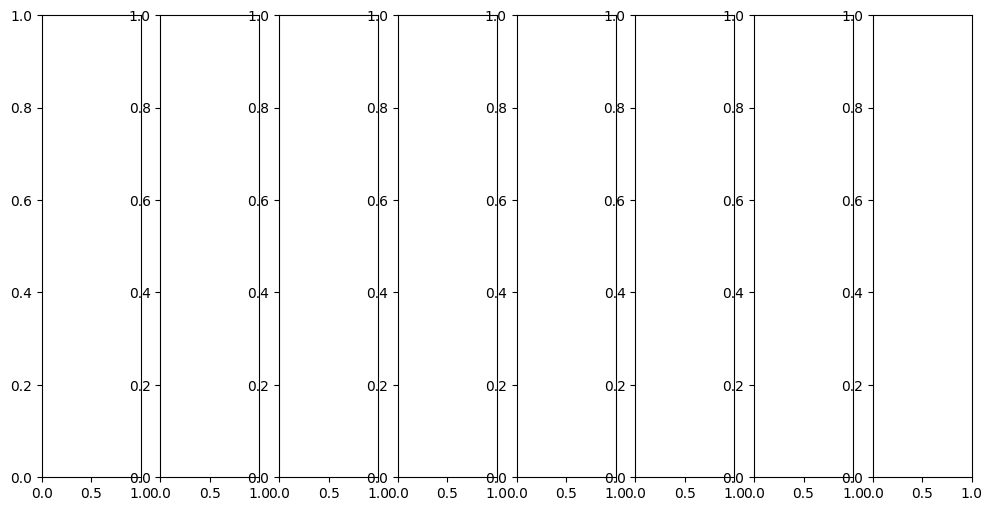

In [138]:
fig, axes = plt.subplots(ncols=len(sim_csvs)+2,figsize=(12,6))
df.boxplot('duration', ax=axes[0])
axes[0].set_ylim(0,60)
axes[0].set_title('Tira')

df_1k.boxplot('duration', ax=axes[1])
axes[1].set_ylim(0,60)
axes[1].set_title('Tira concat')

for i, csv_path in enumerate(sim_csvs):
    sim_df=pd.read_csv(csv_path)
    sim_df['duration']=sim_df['num_samples']/16_000
    sim_df.boxplot('duration', ax=axes[i+2])
    language=sim_df['language'].iloc[0]
    axes[i+2].set_title(language)
    axes[i+2].set_ylim(0,60)

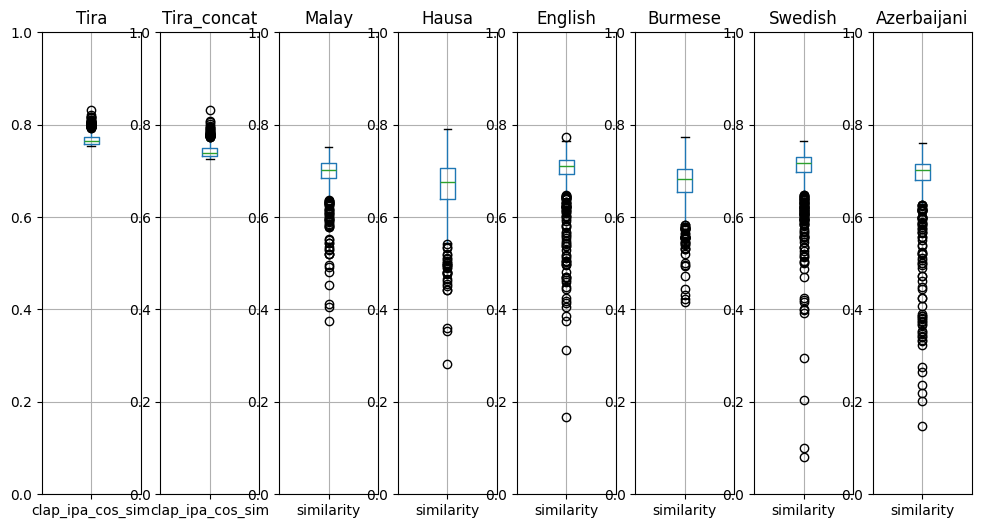

In [95]:
fig, axes = plt.subplots(ncols=len(sim_csvs)+2,figsize=(12,6))
df.iloc[:1000].boxplot('clap_ipa_cos_sim', ax=axes[0])
axes[0].set_title('Tira')
axes[0].set_ylim(0,1)

df_1k.boxplot('clap_ipa_cos_sim', ax=axes[1])
axes[1].set_title('Tira_concat')
axes[1].set_ylim(0,1)

for i, csv_path in enumerate(sim_csvs):
    sim_df=pd.read_csv(csv_path)
    sim_df.boxplot('similarity', ax=axes[i+2])
    language=sim_df['language'].iloc[0]
    axes[i+2].set_title(language)
    axes[i+2].set_ylim(0,1)

# Make clean Tira ASR dataset

In [141]:
clean_df=df[
    (df['pcnt_speech']>=0.6) &
    (df['clap_ipa_cos_sim']>=0.6)
]
clean_df.shape, clean_df['duration'].sum()/3_600

((20480, 27), 11.253147499999999)

In [ ]:
tira_clean_dir='/Users/markjos/projects/malachor5/data/tira-clean'
clean_df['file_name']=clean_df.apply(lambda clip: copy_clip(clip, tira_clean_dir))